In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-poster')

In [2]:
!pwd

/Users/ih64/Desktop/ML_projects/regression


In [2]:
t = pd.read_csv('../datasets/house-prices-advanced-regression-techniques/train.csv')
t.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [17]:
s = (t.dtypes == 'object')
object_cols = list(s[s].index)
size = len(t)
thresh = .2
colsToKeep = []

for c in object_cols:
    nnans = np.where(t[c].isnull())[0].size
    fracNans = nnans/size
    if fracNans < thresh:
        colsToKeep.append(c)

In [23]:
X_label = t.loc[:,colsToKeep]
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_label_imputed = imputer.fit_transform(X_label)
X_label_imputed = pd.DataFrame(X_label_imputed, columns=colsToKeep)
X_label_imputed.describe()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,5,2,4,4,2,5,3,25,9,8,...,5,4,7,6,3,5,5,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
freq,1151,1454,925,1311,1459,1052,1382,225,1260,1445,...,1335,735,1360,951,686,1392,1407,1340,1267,1198


In [37]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
for col in X_label_imputed.columns:
    X_label_imputed[col] = label_encoder.fit_transform(X_label_imputed[col])

In [30]:
X_num = t.select_dtypes(exclude=['object']).drop('SalePrice', axis=1)
numCols = X_num.columns
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_num_imputed = imputer.fit_transform(X_num)
X_num_imputed = pd.DataFrame(X_num_imputed, columns=numCols)
X_num_imputed.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,69.863699,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,421.610009,42.300571,22.027677,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [44]:
X = pd.concat([X_num_imputed, X_label_imputed], axis=1).drop('Id', axis=1)

In [31]:
y = t['SalePrice']

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [40]:
from sklearn.feature_selection import mutual_info_regression
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [48]:
discrete_features = X.dtypes == int

In [49]:
mi_scores = make_mi_scores(X,y, discrete_features=discrete_features )

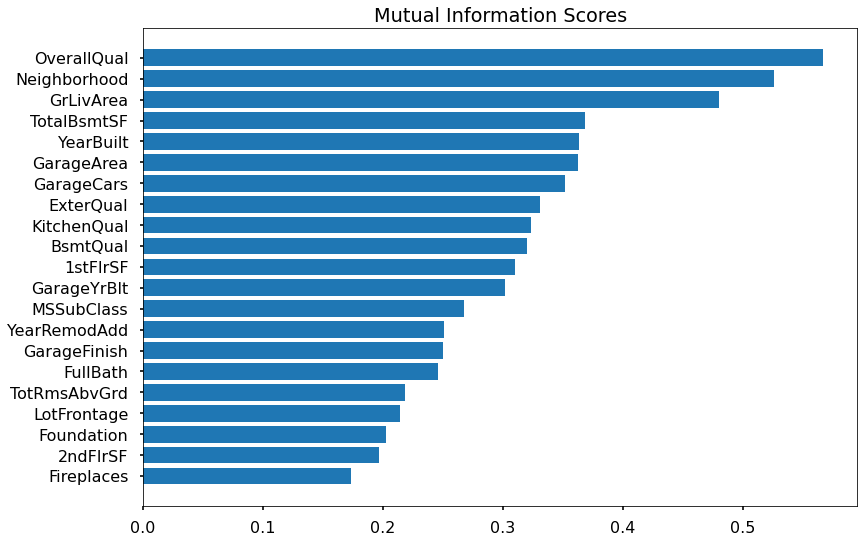

In [58]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure()
plot_mi_scores(mi_scores[:21])

Calculate the pearson correlation coefficent 

r = $\frac{\sum (x - \bar{x}) (y - \bar{y})}{\sum \sqrt{(x - \bar{x})^2(y- \bar{y})^2}}$

amoung all the numerical features. We will deal with the categorical data in a bit, this will help us examine which features correlate strongly with the target variable so we can select them

<AxesSubplot:>

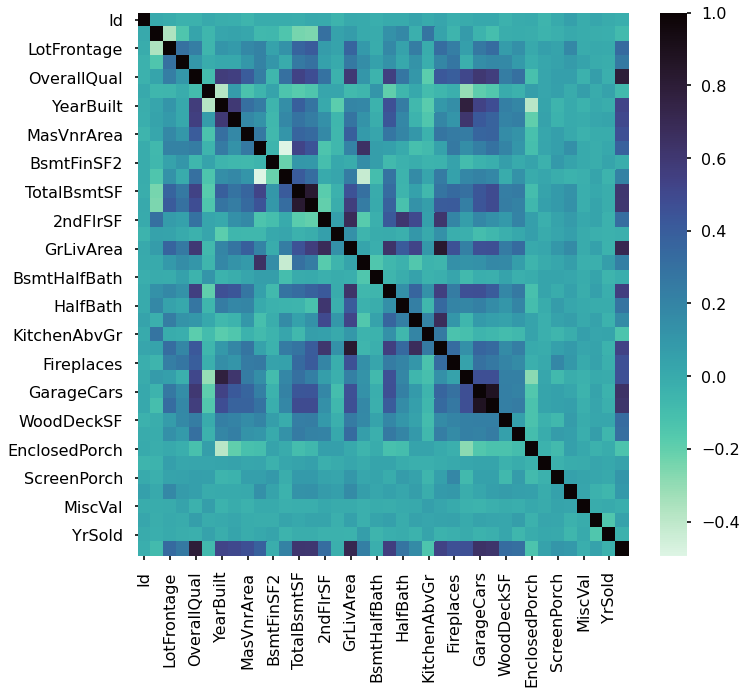

In [59]:
corr = pd.concat([X_num_imputed,y], axis=1).corr()
f, ax = plt.subplots(figsize=(11, 10))
sns.heatmap(corr, annot=False, cmap='mako_r')

In [60]:
corr

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.009921,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.051071,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.356718,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023573,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.009921,-0.356718,1.000000,0.304522,0.234812,-0.053281,0.116685,0.083348,0.178469,0.214367,...,0.075542,0.137014,0.010287,0.061945,0.037655,0.180819,-0.000255,0.010451,0.006380,0.334771
LotArea,-0.033226,-0.139781,0.304522,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103321,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.234812,0.105806,1.000000,-0.091932,0.572323,0.550684,0.407252,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.053281,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.116685,0.014228,0.572323,-0.375983,1.000000,0.592855,0.311600,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.083348,0.013788,0.550684,0.073741,0.592855,1.000000,0.176529,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.051071,0.023573,0.178469,0.103321,0.407252,-0.125694,0.311600,0.176529,1.000000,0.261256,...,0.159991,0.122528,-0.109907,0.019144,0.062248,0.011928,-0.029512,-0.006723,-0.008317,0.472614
BsmtFinSF1,-0.005024,-0.069836,0.214367,0.214103,0.239666,-0.046231,0.249503,0.128451,0.261256,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


In [61]:
# this is like doing a sort on the salePrice column
cols = corr.nlargest(20, 'SalePrice')['SalePrice'].index

In [62]:
cols

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'Fireplaces', 'GarageYrBlt', 'BsmtFinSF1',
       'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'HalfBath'],
      dtype='object')

In [74]:
mi_scores[:20].index

Index(['OverallQual', 'Neighborhood', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt',
       'GarageArea', 'GarageCars', 'ExterQual', 'KitchenQual', 'BsmtQual',
       '1stFlrSF', 'GarageYrBlt', 'MSSubClass', 'YearRemodAdd', 'GarageFinish',
       'FullBath', 'TotRmsAbvGrd', 'LotFrontage', 'Foundation', '2ndFlrSF'],
      dtype='object')

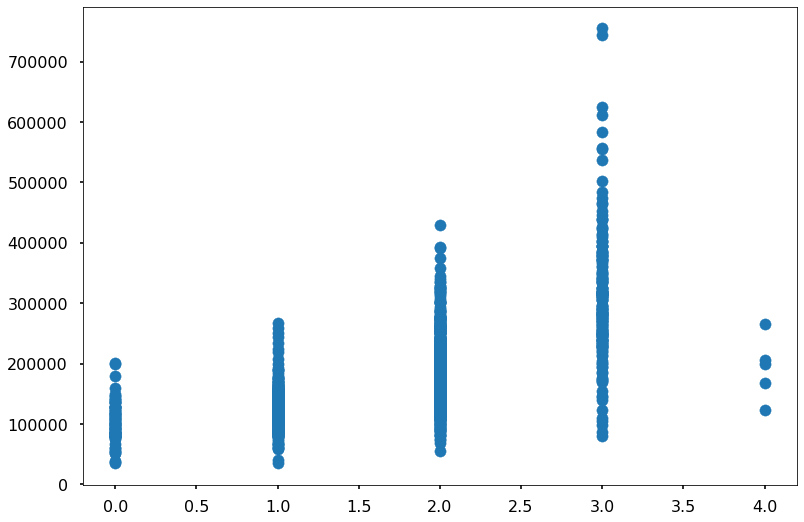

In [72]:
plt.scatter(X['GarageCars'], y)

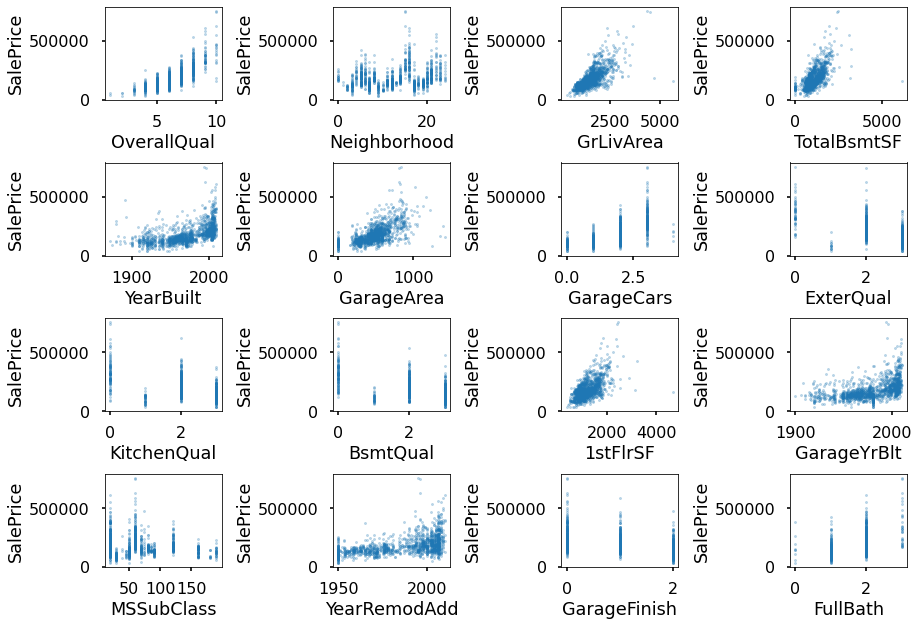

In [79]:
fig, ax = plt.subplots(ncols=4, nrows=4)

features = mi_scores[:16].index
for i, a in zip(features,ax.flatten()):
    a.scatter(X[i], y,s=5, alpha=.3)
    a.set_xlabel(i)
    a.set_ylabel('SalePrice')
plt.tight_layout()

In [86]:
from sklearn.linear_model import LinearRegression
features = ['OverallQual','GrLivArea','TotalBsmtSF','YearBuilt','GarageArea',
           'GarageCars','1stFlrSF','GarageYrBlt','YearRemodAdd']
reg = LinearRegression().fit(X_train.loc[:,features], y_train)
ypred = reg.predict(X_test.loc[:,features])
np.sqrt(np.square(y_test - ypred)).mean()

23373.85860915338

In [115]:
reg = LinearRegression().fit(X_train, y_train)
ypred = reg.predict(X_test)
np.sqrt(np.square(y_test - ypred)).mean()

19916.86852028478

In [114]:
from sklearn.model_selection import GridSearchCV
parameters = {'alpha':[.01,.1,1,2,3,4,5,6,7,8,9,10]}
#parameters = {'alpha':[.01,.1]}
reg = Ridge()
clf = GridSearchCV(reg, parameters)
res = clf.fit(X_train,y_train)
alpha_best = res.best_params_
reg = Ridge(**alpha_best).fit(X_train,y_train)
ypred = reg.predict(X_test)
np.sqrt(np.square(y_test - ypred)).mean()

19626.710192300652

In [109]:
from sklearn.model_selection import GridSearchCV
parameters = {'alpha':[.01,.1,1,2,3,4,5,6,7,8,9,10]}
#parameters = {'alpha':[.01,.1]}
reg = Lasso()
clf = GridSearchCV(reg, parameters)
res = clf.fit(X_train,y_train)
alpha_best = res.best_params_
reg = Lasso(**alpha_best).fit(X_train,y_train)
ypred = reg.predict(X_test)
np.sqrt(np.square(y_test - ypred)).mean()

/Users/ih64/opt/anaconda3/envs/astro/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48507545307.54492, tolerance: 571517926.7044508
  model = cd_fast.enet_coordinate_descent(
/Users/ih64/opt/anaconda3/envs/astro/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48512911664.39551, tolerance: 571517926.7044508
  model = cd_fast.enet_coordinate_descent(
/Users/ih64/opt/anaconda3/envs/astro/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48566442300.32153, tolerance: 571517926.7044508
  model = cd_fast.enet_coordinate_descent(
/Users/ih64/opt/anaconda3/envs/astro/lib/py

19842.780185296146